In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os
import pandas as pd
import math
import warnings
from sklearn.metrics import mean_squared_error
from matplotlib.dates import YearLocator, DateFormatter
from statsmodels.tsa.stattools import grangercausalitytests

import sys
sys.path.insert(0, os.path.abspath('../Libraries'))
import countries as cLib
import ruptures as rpt

In [4]:
# Load productivity dataset
df_productivity = pd.read_csv('../Datasets/cleaned_Productivity.csv')
df_productivity = df_productivity.apply(pd.to_numeric, errors='ignore')
df_productivity.drop('mean', inplace=True, axis=1)

# convert column headers to datetime
df_productivity.columns = pd.to_datetime(df_productivity.columns, format='%A', errors='ignore')

# Drop columns before 2005
df_productivity = df_productivity.drop(df_productivity.columns[1:6], axis=1)
df_productivity.head()

,LOCATION,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,AUS,47.099677,47.342066,47.873036,49.523676,49.111719,49.886548,50.465688,51.671243,52.558753,52.780926,54.099648,53.945416,54.561035,54.559641,55.212012,56.214321,56.820351
1,AUT,60.632340,62.218785,63.814049,63.814456,63.363388,64.291488,64.947960,65.645538,66.080679,66.327394,67.267651,67.184974,67.999464,68.309455,68.309868,69.970148,69.634603
2,BEL,67.287921,67.637137,68.887444,68.464336,68.020751,69.053627,68.581978,68.923207,69.517696,70.513657,71.604653,71.674769,71.534022,71.681631,72.259271,74.541737,73.607184
3,BGR,17.965425,18.618248,19.229785,19.475667,19.717737,20.847786,21.781488,22.497211,22.460713,22.607390,23.296069,23.897609,24.130056,24.784139,25.687153,25.775778,26.559335
4,CAN,47.187987,47.742663,47.802103,47.658733,47.877704,48.405298,49.181535,49.335662,50.068609,51.425818,51.340885,51.524774,52.346352,52.543577,52.996192,56.971404,53.969872


In [5]:
# Load and clean ESI dataset
df_esi = pd.read_csv('../Datasets/ESI_Clean.csv', header=1, nrows=None)
df_esi.rename({'Month-Year': 'LOCATION'}, axis=1, inplace=True)

# Remove '.ESI' in the locations column and convert to alpha-3
df_esi['LOCATION'] = df_esi['LOCATION'].apply(lambda x: x.split('.')[0])

# if alpha-2 code in alpha_2_to_3_map, convert to alpha-3, else drop the row
df_esi['LOCATION'] = df_esi['LOCATION'].apply(lambda x: cLib.convert_alpha_2_to_3(x) if x in cLib.get_alpha_2_list() else np.nan)
df_esi.dropna(inplace=True)
df_esi.reset_index(drop=True, inplace=True)

# convert all column headers to datetime
df_esi.columns = pd.to_datetime(df_esi.columns, format='%b-%y', errors='ignore')

# convert all values to numeric
df_esi = df_esi.apply(pd.to_numeric, errors='ignore')

# save to csv
df_esi.to_csv('../Datasets/ESI_Clean_clean.csv', index=False)
df_esi.head()

,LOCATION,Jan-05,Feb-05,Mar-05,Apr-05,May-05,Jun-05,Jul-05,Aug-05,Sep-05,...,May-22,Jun-22,Jul-22,Aug-22,Sep-22,Oct-22,Nov-22,Dec-22,Jan-23,Feb-23
0,BEL,105.3,104.4,102.6,98.1,94.6,97.0,94.8,96.9,99.9,...,97.8,97.7,98.0,92.9,86.0,83.4,82.4,88.0,87.4,88.9
1,BGR,112.4,106.2,106.3,108.1,108.7,112.4,109.9,101.7,107.3,...,95.0,98.7,100.0,99.4,99.4,100.1,103.4,103.5,101.6,102.1
2,CZE,108.9,108.6,105.4,105.2,108.0,105.9,110.2,106.9,109.1,...,97.0,95.0,89.5,87.7,89.5,83.9,82.2,83.3,88.5,92.0
3,DNK,106.3,107.6,106.0,97.6,100.9,100.2,96.9,106.7,102.6,...,94.2,88.5,86.2,90.0,82.4,74.5,78.7,77.7,78.3,79.6
4,DEU,94.1,92.9,90.7,91.4,92.1,91.4,92.8,94.2,95.3,...,106.6,104.6,99.4,97.0,92.7,91.6,92.9,95.3,97.8,97.9


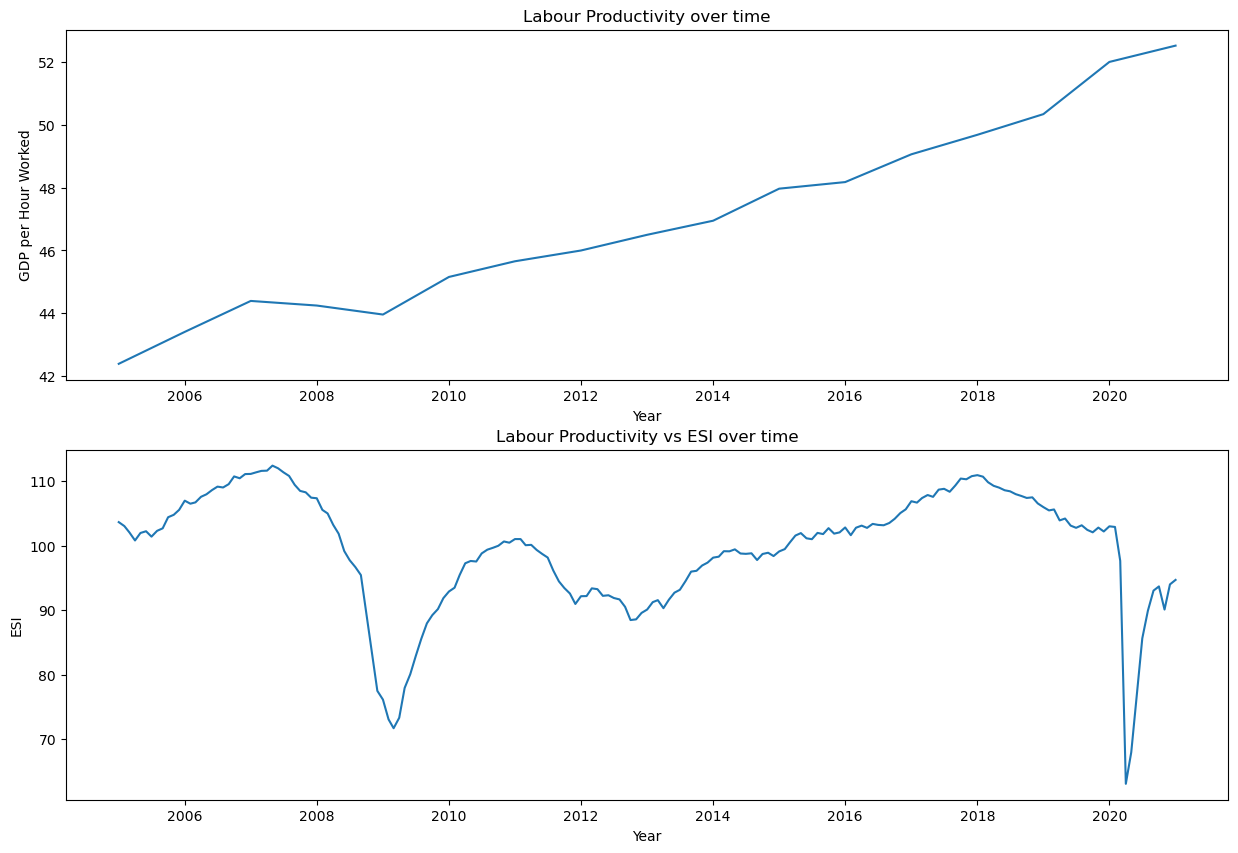

In [6]:
# Get means of productivity and ESI
A = df_productivity.mean(axis=0, numeric_only=True)
B = df_esi.mean(axis=0, numeric_only=True)
B = B[:-25] # don't include anything past Dec 2021

# Combined the dataframes together and sort by date
A = A.T
A.index = A.index.map(lambda x: 'Jan-'+x[-2:])
A.index = pd.to_datetime(A.index, format='%b-%y')

B = B.T
B.index = pd.to_datetime(B.index, format='%b-%y', errors='ignore')

fig, ax = plt.subplots(2, 1, figsize=(15, 10))
ax[0].plot(A, label='Productivity')
ax[0].set_xlabel('Year')
ax[0].set_ylabel('GDP per Hour Worked')
ax[0].set_title('Labour Productivity over time')

ax[1].plot(B, label='ESI')
ax[1].set_xlabel('Year')
ax[1].set_ylabel('ESI')
ax[1].set_title('ESI over time')

plt.title('Labour Productivity vs ESI over time')
plt.show()

# Correlations

In [7]:
# Resample productivity to monthly
df_A = A.to_frame()
df_B = B.to_frame()
# df_A.columns = ['Productivity']
# df_B.columns = ['ESI']
df_A = df_A.resample('MS').ffill() # need to fill from start of month to match with df_B

# Get correlations
# print(len(df_A), len(df_B))
df_A.corrwith(df_B)

0    0.016244
dtype: float64

## Remove the breakpoints

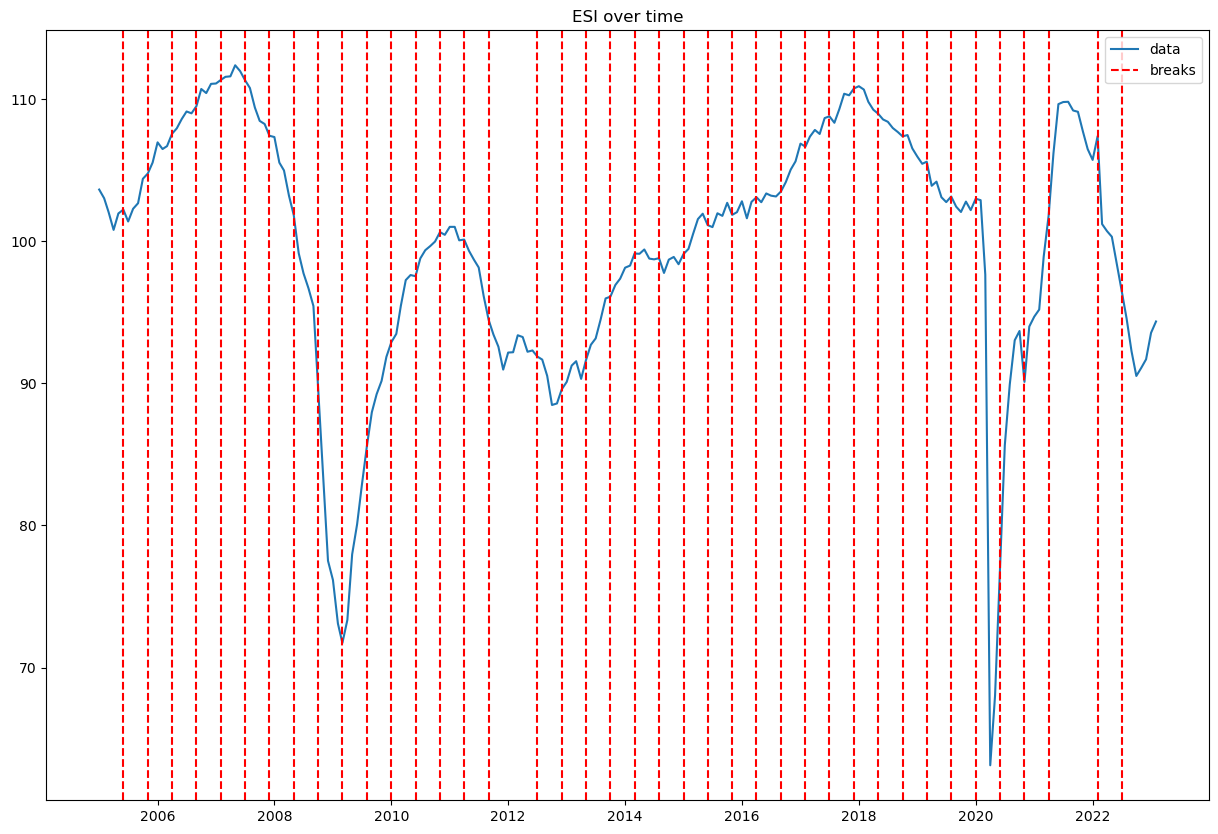

[Timestamp('2005-06-01 00:00:00'), Timestamp('2005-11-01 00:00:00'), Timestamp('2006-04-01 00:00:00'), Timestamp('2006-09-01 00:00:00'), Timestamp('2007-02-01 00:00:00'), Timestamp('2007-07-01 00:00:00'), Timestamp('2007-12-01 00:00:00'), Timestamp('2008-05-01 00:00:00'), Timestamp('2008-10-01 00:00:00'), Timestamp('2009-03-01 00:00:00'), Timestamp('2009-08-01 00:00:00'), Timestamp('2010-01-01 00:00:00'), Timestamp('2010-06-01 00:00:00'), Timestamp('2010-11-01 00:00:00'), Timestamp('2011-04-01 00:00:00'), Timestamp('2011-09-01 00:00:00'), Timestamp('2012-07-01 00:00:00'), Timestamp('2012-12-01 00:00:00'), Timestamp('2013-05-01 00:00:00'), Timestamp('2013-10-01 00:00:00'), Timestamp('2014-03-01 00:00:00'), Timestamp('2014-08-01 00:00:00'), Timestamp('2015-01-01 00:00:00'), Timestamp('2015-06-01 00:00:00'), Timestamp('2015-11-01 00:00:00'), Timestamp('2016-04-01 00:00:00'), Timestamp('2016-09-01 00:00:00'), Timestamp('2017-02-01 00:00:00'), Timestamp('2017-07-01 00:00:00'), Timestamp('20

In [61]:
df_esi_mean = df_esi.mean(axis=0, numeric_only=True)
df_esi_mean.index = pd.to_datetime(df_esi_mean.index, format='%b-%y', errors='ignore')
dates = df_esi_mean.index
data = df_esi_mean.values

model = rpt.BottomUp()
model.fit(data)
breaks = model.predict(n_bkps=40)
breaks_rpt = []
for i in breaks:
    if i < len(dates):
        breaks_rpt.append(dates[i])

plt.figure(figsize=(15, 10))
plt.plot(dates, data, label='data')
plt.title('ESI over time')
print_legend = True
for i in breaks_rpt:
    if print_legend:
        plt.axvline(i, color='red',linestyle='dashed', label='breaks')
        print_legend = False
    else:
        plt.axvline(i, color='red',linestyle='dashed')

plt.legend()
plt.show()

print(breaks_rpt)

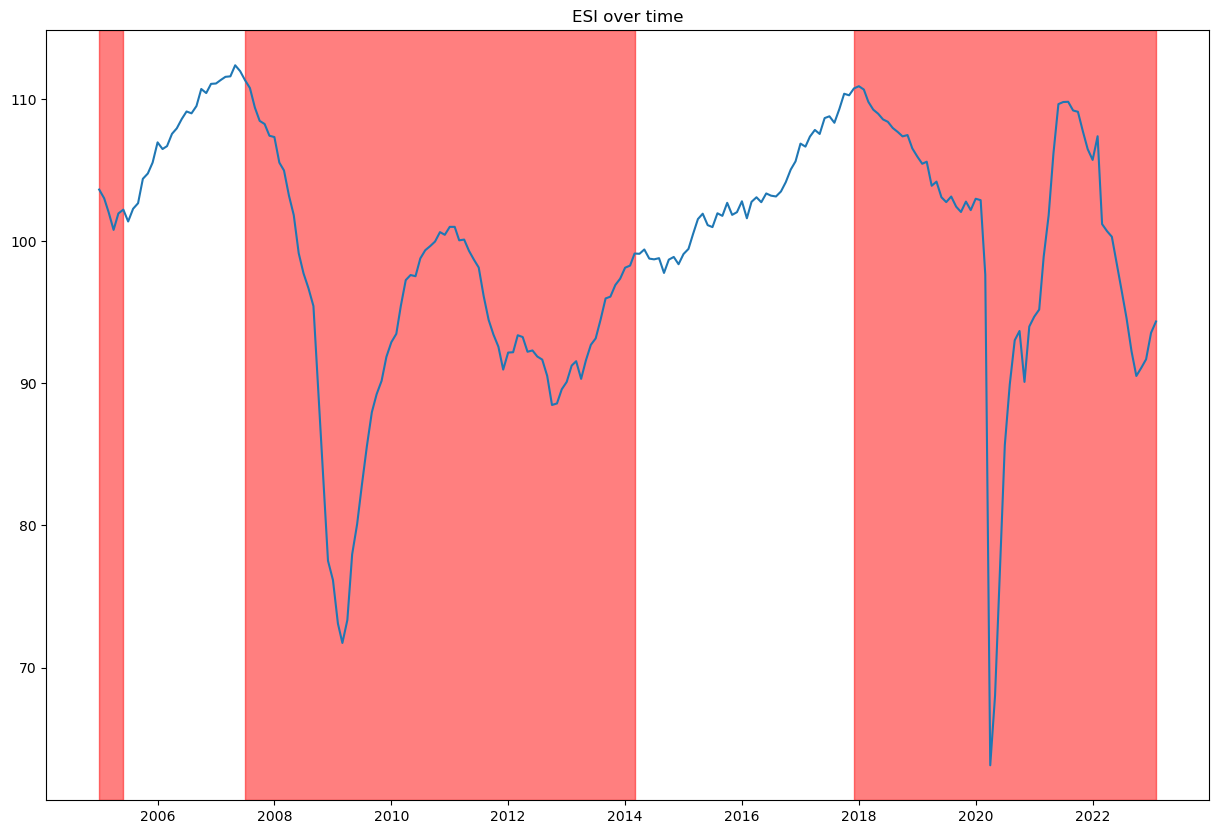

[Timestamp('2005-01-01 00:00:00'), Timestamp('2005-06-01 00:00:00')]
[Timestamp('2007-07-01 00:00:00'), Timestamp('2014-03-01 00:00:00')]
[Timestamp('2017-12-01 00:00:00'), Timestamp('2023-02-01 00:00:00')]


In [50]:
# Illustrate the areas of data that you will ignore
area0 = [dates[0], breaks_rpt[0]]
area1 = [breaks_rpt[5], breaks_rpt[20]]
area2 = [breaks_rpt[29], dates[-1]]
sections_to_remove = [area0, area1, area2]
plt.figure(figsize=(15, 10))
plt.plot(dates, data)
plt.title('ESI over time')

for i in sections_to_remove:
    plt.axvspan(i[0], i[1], alpha=0.5, color='red')

plt.show()

print(area0)
print(area1)
print(area2)

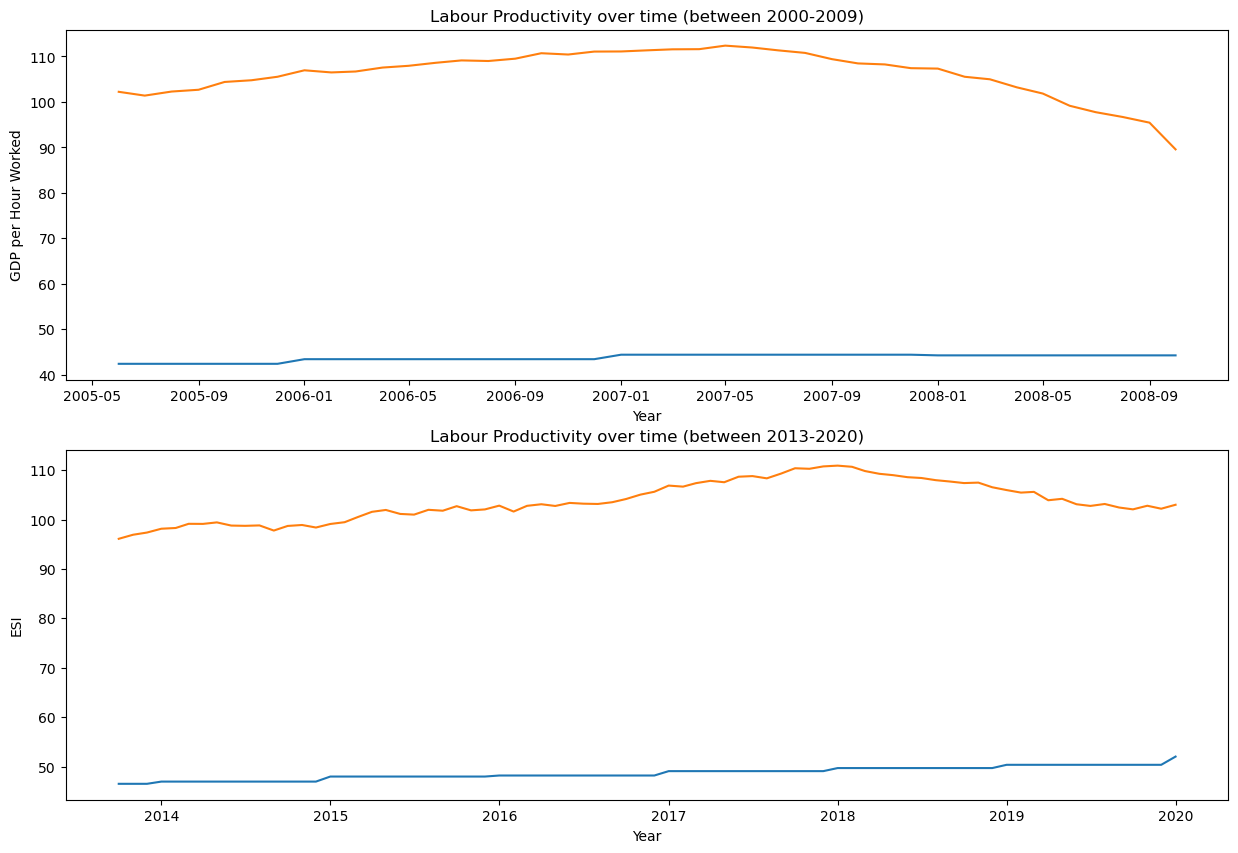

In [62]:
# Remove the data for troughs
df_A_2005 = df_A.loc['2005-06-01':'2008-10-01']
df_A_2013 = df_A.loc['2013-10-01':'2020-01-01']

df_B_2005 = df_B.loc['2005-06-01':'2008-10-01']
df_B_2013 = df_B.loc['2013-10-01':'2020-01-01']

# Plot the data
fig, ax = plt.subplots(2, 1, figsize=(15, 10))
ax[0].plot(df_A_2005, label='Productivity')
ax[0].plot(df_B_2005, label='ESI')
ax[0].set_xlabel('Year')
ax[0].set_ylabel('GDP per Hour Worked')
ax[0].set_title('Labour Productivity over time (between 2000-2009)')

ax[1].plot(df_A_2013, label='Productivity')
ax[1].plot(df_B_2013, label='ESI')
ax[1].set_xlabel('Year')
ax[1].set_ylabel('ESI')
ax[1].set_title('Labour Productivity over time (between 2013-2020)')
plt.show()

In [52]:
# Calculate correlations
result_2005 = df_A_2005.corrwith(df_B_2005)
result_2013 = df_A_2013.corrwith(df_B_2013)
print(result_2005)
print(result_2013)

0    0.132675
dtype: float64
0    0.670639
dtype: float64


In short: very little correlation between productivity and ESI if you include the breakpoints. If you remove them, there is a strong correlation.

# Causality

In [53]:
# REFERENCE: https://www.statology.org/granger-causality-test-in-python/
# Use Granger Causality tests to see if there is a relationship between the variables

# Combine the dataframes
df_combined = pd.concat([df_A, df_B], axis=1)
df_combined.columns = ['Productivity', 'ESI']

results1 = grangercausalitytests(df_combined, maxlag=2, verbose=False)

# If the p-value is less than 0.05, then the null hypothesis is rejected and there is a Granger Causality
if results1.get(1)[0]['ssr_ftest'][1] < 0.05:
    print('ESI is a predictor variable of Labour Productivity', results1.get(1)[0]['ssr_ftest'][1])

results2 = grangercausalitytests(df_combined[['ESI', 'Productivity']], maxlag=2, verbose=False)
if results2.get(1)[0]['ssr_ftest'][1] < 0.05:
    print('Labour Productivity is a predictor variable of ESI:', results2.get(1)[0]['ssr_ftest'][1])

if results1.get(1)[0]['ssr_ftest'][1] >= 0.05 and results2.get(1)[0]['ssr_ftest'][1] >= 0.05:
    print('There is no Granger Causality between the variables:', results1.get(1)[0]['ssr_ftest'][1], results2.get(1)[0]['ssr_ftest'][1])

There is no Granger Causality between the variables: 0.42218829347090814 0.7427250479893299


In [59]:
# Granger causality for the 2000-2008 period
results3 = grangercausalitytests(df_combined.loc['2005-06-01':'2008-10-01'], maxlag=2, verbose=False)

# If the p-value is less than 0.05, then the null hypothesis is rejected and there is a Granger Causality   
if results3.get(1)[0]['ssr_ftest'][1] < 0.05:
    print('ESI is a predictor variable of Labour Productivity for 2000-2008:', results3.get(1)[0]['ssr_ftest'][1])

results4 = grangercausalitytests(df_combined.loc['2005-06-01':'2008-10-01'][['ESI', 'Productivity']], maxlag=2, verbose=False)
if results4.get(1)[0]['ssr_ftest'][1] < 0.05:
    print('Labour Productivity is a predictor variable of ESI for 2000-2008:', results4.get(1)[0]['ssr_ftest'][1])

if results3.get(1)[0]['ssr_ftest'][1] >= 0.05 and results4.get(1)[0]['ssr_ftest'][1] >= 0.05:
    print('There is no Granger Causality between the variables:', results3.get(1)[0]['ssr_ftest'][1], results4.get(1)[0]['ssr_ftest'][1])

Labour Productivity is a predictor variable of ESI for 2000-2008: 7.446017398614728e-07


In [58]:
# Granger causality for the 2013-2020 period
results5 = grangercausalitytests(df_combined.loc['2013-10-01':'2020-01-01'], maxlag=2, verbose=False)

# If the p-value is less than 0.05, then the null hypothesis is rejected and there is a Granger Causality
if results5.get(1)[0]['ssr_ftest'][1] < 0.05:
    print('ESI is a predictor variable of Labour Productivity for 2013-2020:', results5.get(1)[0]['ssr_ftest'][1])

results6 = grangercausalitytests(df_combined.loc['2013-10-01':'2020-01-01'][['ESI', 'Productivity']], maxlag=2, verbose=False)
if results6.get(1)[0]['ssr_ftest'][1] < 0.05:
    print('Labour Productivity is a predictor variable of ESI for 2013-2020:', results6.get(1)[0]['ssr_ftest'][1])

if results5.get(1)[0]['ssr_ftest'][1] >= 0.05 and results5.get(1)[0]['ssr_ftest'][1] >= 0.05:
    print('There is no Granger Causality between the variables:', results5.get(1)[0]['ssr_ftest'][1], results6.get(1)[0]['ssr_ftest'][1])

There is no Granger Causality between the variables: 0.43316089558317505 0.053917674616687866
